In [159]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import numpy as np
from tsfresh import extract_features
import plotly.graph_objs as go
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,  f1_score

In [160]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [161]:
data_to_extract=pd.read_csv("..\chapter4\data_to_extraction.csv").drop(columns="Unnamed: 0")
data_to_extract.columns

Index(['PACJENT_NR', 'BADANIE_NR', 'BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE',
       'O2SATTET', 'O2TET', 'IONH', 'ZGON', 'BETET_kw', 'O2TET_kw',
       'HCO3ACTE_kw', 'HCO3STTE_kw', 'O2SATTET_kw', 'IONH_kw', 'CO2TET_kw',
       'BETET_pn', 'O2TET_pn', 'HCO3ACTE_pn', 'HCO3STTE_pn', 'O2SATTET_pn',
       'IONH_pn', 'CO2TET_pn', 'euclidean_kw', 'euclidean_kw_skum'],
      dtype='object')

In [299]:
data_to_extract.groupby("PACJENT_NR").last()["BADANIE_NR"].max()

64

In [163]:
y=data_to_extract.groupby("PACJENT_NR").last()["ZGON"].reset_index(drop=True)

In [164]:
var_columns=['BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE',
       'O2SATTET', 'O2TET', 'IONH', 'BETET_kw', 'O2TET_kw',
       'HCO3ACTE_kw', 'HCO3STTE_kw', 'O2SATTET_kw', 'IONH_kw', 'CO2TET_kw',
       'BETET_pn', 'O2TET_pn', 'HCO3ACTE_pn', 'HCO3STTE_pn', 'O2SATTET_pn',
       'IONH_pn', 'CO2TET_pn', 'euclidean_kw', 'euclidean_kw_skum']


In [165]:
len(var_columns)

23

In [644]:
selected_features = {
    'minimum': None,
    'maximum': None,
    'mean': None,
    'median': None,
    'variance': None,
    'number_peaks': [{'n': 2}, {'n': 4}],
    'first_location_of_minimum': None,
    'first_location_of_maximum': None,
    'linear_trend': [{'attr': 'slope'}],
    'agg_linear_trend': [
        {'f_agg': 'mean', 'chunk_len': 3, 'attr': 'slope'},
        {'f_agg': 'mean', 'chunk_len': 6, 'attr': 'slope'},
        {'f_agg': 'max', 'chunk_len': 3, 'attr': 'slope'},
        {'f_agg': 'max', 'chunk_len': 6, 'attr': 'slope'}
    ]
}

extracted_features = pd.DataFrame()

for col in var_columns:
    features = extract_features(data_to_extract, column_id="PACJENT_NR", column_sort="BADANIE_NR", 
                                column_value=col, default_fc_parameters=selected_features)
    extracted_features = pd.concat([extracted_features, features], axis=1)

extracted_features 

Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  5.73it/s]


,BETET__minimum,BETET__maximum,BETET__mean,BETET__median,BETET__variance,BETET__number_peaks__n_2,BETET__number_peaks__n_4,BETET__first_location_of_minimum,BETET__first_location_of_maximum,"BETET__linear_trend__attr_""slope""",...,euclidean_kw_skum__variance,euclidean_kw_skum__number_peaks__n_2,euclidean_kw_skum__number_peaks__n_4,euclidean_kw_skum__first_location_of_minimum,euclidean_kw_skum__first_location_of_maximum,"euclidean_kw_skum__linear_trend__attr_""slope""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""max""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""max"""
1,0.086957,6.260870,3.212790,3.065217,2.015770,7.0,3.0,0.020000,0.220000,-0.005501,...,182.042449,0.0,0.0,0.0,0.980000,0.913771,2.751726,5.494292,2.717326,5.297220
2,-0.043478,2.304348,1.332609,1.173913,0.531479,0.0,0.0,0.000000,0.900000,0.243083,...,24.929782,0.0,0.0,0.0,0.800000,1.700442,4.159130,8.097602,3.299999,3.980000
3,0.478261,4.086957,2.179745,1.934783,0.734497,6.0,2.0,0.000000,0.243902,-0.033162,...,22.519226,0.0,0.0,0.0,0.926829,0.370867,1.079482,2.155931,1.016063,1.785982
4,-0.065217,3.500000,1.605499,1.456522,0.630021,4.0,1.0,0.705882,0.176471,-0.034773,...,23.542215,0.0,0.0,0.0,0.970588,0.397114,1.321238,2.571625,1.424427,3.092883
6,-0.043478,0.847826,0.478261,0.554348,0.067580,1.0,0.0,0.750000,0.375000,-0.054348,...,2.745903,0.0,0.0,0.0,0.750000,0.667426,1.736074,1.911147,1.322074,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.652174,5.347826,3.311141,3.358696,1.228126,4.0,2.0,0.031250,0.343750,0.032322,...,149.693755,0.0,0.0,0.0,0.968750,1.314109,3.895106,7.393326,3.866095,7.175720
140,-0.347826,3.934783,2.571558,2.869565,1.115528,4.0,1.0,0.000000,0.583333,0.081749,...,17.831701,0.0,0.0,0.0,0.958333,0.604629,1.813145,3.614941,1.815859,3.562553
142,0.391304,4.565217,2.884058,2.913043,1.841675,2.0,1.0,0.047619,0.666667,0.148278,...,178.999056,0.0,0.0,0.0,0.952381,2.196274,6.576850,12.499477,6.791721,11.936108
144,0.739130,3.282609,2.029644,1.956522,0.518755,0.0,0.0,0.000000,0.909091,0.189921,...,115.582655,0.0,0.0,0.0,0.909091,3.392153,9.627781,18.755566,9.219570,15.212494


In [167]:
names=extracted_features.columns

In [168]:
len(names)

322

In [169]:
data_with_features=pd.concat([data_to_extract[['PACJENT_NR', 'ZGON']].groupby("PACJENT_NR").last()["ZGON"], extracted_features], axis=1).rename_axis("PACJENT_NR").reset_index()
data_with_features

,PACJENT_NR,ZGON,BETET__minimum,BETET__maximum,BETET__mean,BETET__median,BETET__variance,BETET__number_peaks__n_2,BETET__number_peaks__n_4,BETET__first_location_of_minimum,...,euclidean_kw_skum__variance,euclidean_kw_skum__number_peaks__n_2,euclidean_kw_skum__number_peaks__n_4,euclidean_kw_skum__first_location_of_minimum,euclidean_kw_skum__first_location_of_maximum,"euclidean_kw_skum__linear_trend__attr_""slope""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""max""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""max"""
0,1,0.0,0.086957,6.260870,3.212790,3.065217,2.015770,7.0,3.0,0.020000,...,182.042449,0.0,0.0,0.0,0.980000,0.913771,2.751726,5.494292,2.717326,5.297220
1,2,0.0,-0.043478,2.304348,1.332609,1.173913,0.531479,0.0,0.0,0.000000,...,24.929782,0.0,0.0,0.0,0.800000,1.700442,4.159130,8.097602,3.299999,3.980000
2,3,0.0,0.478261,4.086957,2.179745,1.934783,0.734497,6.0,2.0,0.000000,...,22.519226,0.0,0.0,0.0,0.926829,0.370867,1.079482,2.155931,1.016063,1.785982
3,4,0.0,-0.065217,3.500000,1.605499,1.456522,0.630021,4.0,1.0,0.705882,...,23.542215,0.0,0.0,0.0,0.970588,0.397114,1.321238,2.571625,1.424427,3.092883
4,6,0.0,-0.043478,0.847826,0.478261,0.554348,0.067580,1.0,0.0,0.750000,...,2.745903,0.0,0.0,0.0,0.750000,0.667426,1.736074,1.911147,1.322074,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,139,0.0,0.652174,5.347826,3.311141,3.358696,1.228126,4.0,2.0,0.031250,...,149.693755,0.0,0.0,0.0,0.968750,1.314109,3.895106,7.393326,3.866095,7.175720
103,140,1.0,-0.347826,3.934783,2.571558,2.869565,1.115528,4.0,1.0,0.000000,...,17.831701,0.0,0.0,0.0,0.958333,0.604629,1.813145,3.614941,1.815859,3.562553
104,142,0.0,0.391304,4.565217,2.884058,2.913043,1.841675,2.0,1.0,0.047619,...,178.999056,0.0,0.0,0.0,0.952381,2.196274,6.576850,12.499477,6.791721,11.936108
105,144,0.0,0.739130,3.282609,2.029644,1.956522,0.518755,0.0,0.0,0.000000,...,115.582655,0.0,0.0,0.0,0.909091,3.392153,9.627781,18.755566,9.219570,15.212494


In [581]:
X_data = data_with_features.drop(columns=["ZGON", "PACJENT_NR"])
y_data = data_with_features["ZGON"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2, random_state=seed)

In [582]:
X_data.shape

(107, 322)

In [583]:
# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [584]:
def plot_confusion_matrix(model, X_train, X_test, y_train, y_test, ax, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Reds", annot_kws={"fontsize": 14})
    ax.set_title(f'{title}\ndokładność: {accuracy:.2f}, precyzja: {precision:.2f},\nczułość: {recall:.2f}, F1-score: {f1:.2f}', fontsize=16)
    ax.set_xlabel('Przewidywane', fontsize=14)
    ax.set_ylabel('Prawdziwe', fontsize=14)

    # Funkcja do trenowania i mierzenia czasu
def model_evaluate(classifier, X_train, X_test, y_train, y_test):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _= roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


### Klasyfikacja na wszystkich 324 zmiennych

In [612]:
# Klasyfikatory

classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
}

param_grids = {
    'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  'probability': [True]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, None], 'random_state': [seed]},
    'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                      'max_depth': [5, 10, 20, 30, 40, 50,], 'random_state': [seed]}
}


# Przechowywanie najlepszych modeli i ich wyników
best_models_all = {}
best_scores_all = {}
test_scores_all={}

# Przeszukiwanie hiperparametrów dla każdego klasyfikatora
for name, classifier in classifiers.items():
    print(f"Przetwarzanie {name}...")
    grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy',)
    grid_search.fit(X_train_scaled, y_train)
    best_models_all[name] = (type(grid_search.best_estimator_), grid_search.best_params_)
    best_scores_all[name] = grid_search.best_score_
    print(f"Najlepsze parametry dla {name}: {grid_search.best_params_}")
    print(f"Najlepszy wynik dla {name}: {grid_search.best_score_}\n")

# Ocena najlepszych modeli na zbiorze testowym
for name, (model_type, best_params) in best_models_all.items():
    model = model_type(**best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_score = accuracy_score(y_test, y_pred)
    test_scores_all[name]=test_score
    print(f"Dokładność {name} na zbiorze testowym: {test_score}")

Przetwarzanie KNN...
Najlepsze parametry dla KNN: {'n_neighbors': 10, 'weights': 'uniform'}
Najlepszy wynik dla KNN: 0.7884199134199135

Przetwarzanie LDA...
Najlepsze parametry dla LDA: {'solver': 'svd'}
Najlepszy wynik dla LDA: 0.6958874458874459

Przetwarzanie SVC...


c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\skl

Najlepsze parametry dla SVC: {'C': 1, 'kernel': 'sigmoid', 'probability': True}
Najlepszy wynik dla SVC: 0.8116883116883118

Przetwarzanie DT...
Najlepsze parametry dla DT: {'criterion': 'gini', 'max_depth': 10, 'random_state': 42}
Najlepszy wynik dla DT: 0.7294372294372293

Przetwarzanie RF...
Najlepsze parametry dla RF: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10, 'random_state': 42}
Najlepszy wynik dla RF: 0.8122294372294372

Dokładność KNN na zbiorze testowym: 0.7272727272727273
Dokładność LDA na zbiorze testowym: 0.7727272727272727
Dokładność SVC na zbiorze testowym: 0.8181818181818182
Dokładność DT na zbiorze testowym: 0.5909090909090909
Dokładność RF na zbiorze testowym: 0.7727272727272727


In [616]:
best_scores_all

{'KNN': 0.7884199134199135,
 'LDA': 0.6958874458874459,
 'SVC': 0.8116883116883118,
 'DT': 0.7294372294372293,
 'RF': 0.8122294372294372}

In [579]:
best_scores_pca

{'KNN': 0.7532467532467533,
 'LDA': 0.7305194805194806,
 'SVC': 0.8116883116883117,
 'DT': 0.5876623376623377,
 'RF': 0.7418831168831169}

In [607]:
test_scores_all

{'KNN': 0.7272727272727273,
 'LDA': 0.7727272727272727,
 'SVC': 0.8181818181818182,
 'DT': 0.5909090909090909,
 'RF': 0.7727272727272727}

In [578]:
test_scores_pca

{'KNN': 0.8636363636363636,
 'LDA': 0.8181818181818182,
 'SVC': 0.8181818181818182,
 'DT': 0.6363636363636364,
 'RF': 0.6818181818181818}

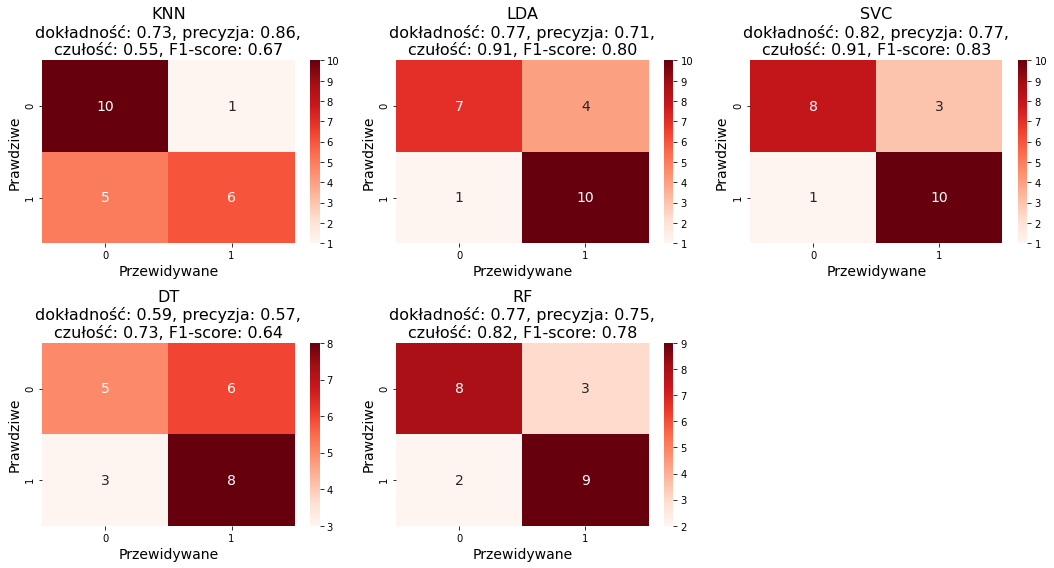

In [593]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Lista tytułów
titles = ['KNN', 'LDA', 'SVC', 'DT', 'RF']

# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_all.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train_scaled, X_test_scaled, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_all.png")

plt.show()

KNeighborsClassifier(n_neighbors=10)
LinearDiscriminantAnalysis()
SVC(C=1, kernel='sigmoid', probability=True)
DecisionTreeClassifier(max_depth=10, random_state=42)
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=10,
                       random_state=42)


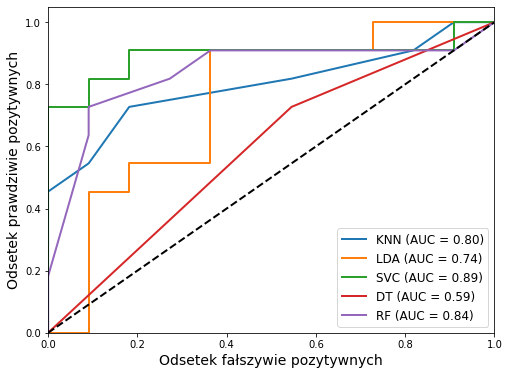

In [613]:
plt.figure(figsize=(8, 6))
for name, (model_type, best_params) in best_models_all.items():
    model = model_type(**best_params)
    print(model)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    fpr, tpr, roc_auc= model_evaluate(model, X_train_scaled, X_test_scaled, y_train, y_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')  # Grubsze linie

# Dodanie linii diagonalnej
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ustawienia osi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Powiększenie napisów przy osiach
plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=14)
plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=14)

# Powiększenie legendy
plt.legend(loc='lower right', fontsize=12)

plt.savefig("images5/roc_all.png")
# Wyświetlenie wykresu
plt.show()

### Klasyfikacja na podstawie najważniejszych skłądowych

In [179]:
# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train_scaled)

# Wyjaśniona wariancja
explained_variance_ratio = pca.explained_variance_ratio_

# Kumulatywna suma wyjaśnionej wariancji
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Tworzenie osypiska (scree plot) za pomocą Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance_ratio) + 1)), y=explained_variance_ratio,
                         mode='lines+markers', name='Explained Variance Ratio'))
# fig.add_trace(go.Scatter(x=list(range(1, len(cumulative_explained_variance_ratio) + 1)), 
#                          y=cumulative_explained_variance_ratio,
#                          mode='lines+markers', name='Cumulative Explained Variance Ratio'))

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title='Liczba składowych',
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Odsetek wariancji',
        tickfont=dict(size=16),
        title_font=dict(size=20)
    )
)
fig.update_layout(template="plotly_white")


# Wyświetlenie wykresu
fig.show()
fig.write_image("images5/osypisko.png", width=1000, height=600, scale=3, format="png")

In [502]:
322/7

46.0

In [ ]:
#PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))

X_pca_df=pd.DataFrame(X_train_pca, columns=['Czynnik 1', 'Czynnik 2', 'Czynnik 3'])
X_pca_df['ZGON'] = y
X_pca_df['Czy pacjent zmarł?'] = X_pca_df['ZGON'].map({1: 'tak', 0: 'nie'})

fig = px.scatter_3d(X_pca_df, x='Czynnik 1', y='Czynnik 2', z='Czynnik 3', color='Czy pacjent zmarł?', size_max=18, opacity=0.8)
fig.update_traces(textposition='top center', marker_size=6)

fig.update_layout(
    scene=dict(
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(tickfont=dict(size=10)),
        zaxis=dict(tickfont=dict(size=10)),
    )
)

fig.update_layout(legend=dict(font=dict(size=14)), legend_title=dict(font=dict(size=14)))
fig.update_layout(template="plotly_white")
fig.show()

# fig.write_image("images5/" + "pca_miernik_3d" + ".png", width=1000, height=600, scale=3, format="png")


In [211]:
pca = PCA(n_components=7) #22
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))

0.6872239458693004


In [614]:
# Klasyfikatory

classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
}


param_grids = {
    'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'gamma': [0.001, 0.01, 0.1, 1],  'probability': [True]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, None], 'random_state': [seed]},
    'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                      'max_depth': [5, 10, 20, 30, 40, 50,], 'random_state': [seed]}
}


# Przechowywanie najlepszych modeli i ich wyników
best_models_pca = {}
best_scores_pca = {}
test_scores_pca= {}

# Przeszukiwanie hiperparametrów dla każdego klasyfikatora
for name, classifier in classifiers.items():
    print(f"Przetwarzanie {name}...")
    grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy',)
    grid_search.fit(X_train_pca, y_train)
    best_models_pca[name] = (type(grid_search.best_estimator_), grid_search.best_params_)
    best_scores_pca[name] = grid_search.best_score_
    print(f"Najlepsze parametry dla {name}: {grid_search.best_params_}")
    print(f"Najlepszy wynik dla {name}: {grid_search.best_score_}\n")

# Ocena najlepszych modeli na zbiorze testowym
for name, (model_type, best_params) in best_models_pca.items():
    model = model_type(**best_params)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    test_score = accuracy_score(y_test, y_pred)
    test_scores_pca[name]=test_score
    print(f"Dokładność {name} na zbiorze testowym: {test_score}")

Przetwarzanie KNN...
Najlepsze parametry dla KNN: {'n_neighbors': 10, 'weights': 'distance'}
Najlepszy wynik dla KNN: 0.8122294372294372

Przetwarzanie LDA...
Najlepsze parametry dla LDA: {'solver': 'svd'}
Najlepszy wynik dla LDA: 0.7646103896103895

Przetwarzanie SVC...
Najlepsze parametry dla SVC: {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid', 'probability': True}
Najlepszy wynik dla SVC: 0.824134199134199

Przetwarzanie DT...
Najlepsze parametry dla DT: {'criterion': 'entropy', 'max_depth': 10, 'random_state': 42}
Najlepszy wynik dla DT: 0.729978354978355

Przetwarzanie RF...
Najlepsze parametry dla RF: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'random_state': 42}
Najlepszy wynik dla RF: 0.8122294372294372

Dokładność KNN na zbiorze testowym: 0.7727272727272727
Dokładność LDA na zbiorze testowym: 0.8181818181818182
Dokładność SVC na zbiorze testowym: 0.7727272727272727
Dokładność DT na zbiorze testowym: 0.6363636363636364
Dokładność RF na zbiorze testowym: 0.681818181

In [600]:
best_scores_pca

{'KNN': 0.8122294372294372,
 'LDA': 0.7646103896103895,
 'SVC': 0.824134199134199,
 'DT': 0.7056277056277056,
 'RF': 0.8122294372294372}

In [601]:
test_scores_pca

{'KNN': 0.7727272727272727,
 'LDA': 0.8181818181818182,
 'SVC': 0.7727272727272727,
 'DT': 0.6363636363636364,
 'RF': 0.7727272727272727}

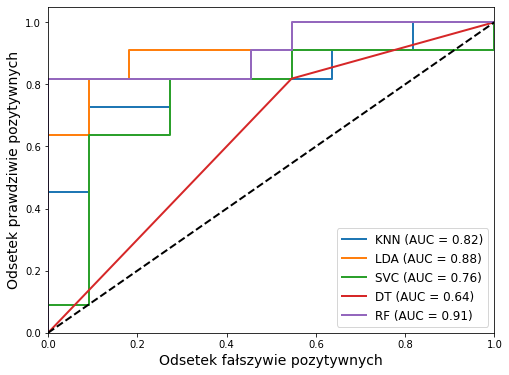

In [615]:
# Krzywe ROC
plt.figure(figsize=(8, 6))
for name, (model_type, best_params) in best_models_pca.items():
    model = model_type(**best_params)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    fpr, tpr, roc_auc= model_evaluate(model, X_train_pca, X_test_pca, y_train, y_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')  # Grubsze linie

# Dodanie linii diagonalnej
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ustawienia osi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Powiększenie napisów przy osiach
plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=14)
plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=14)

# Powiększenie legendy
plt.legend(loc='lower right', fontsize=12)

plt.savefig("images5/roc_pca.png")
# Wyświetlenie wykresu
plt.show()



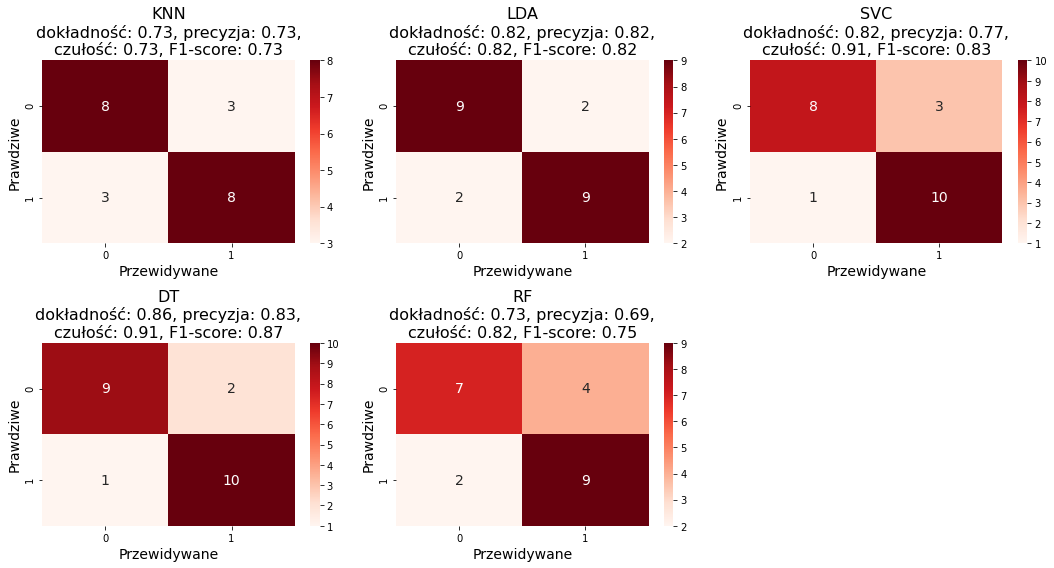

In [603]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Lista tytułów
titles = ['KNN', 'LDA', 'SVC', 'DT', 'RF']

# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_all.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train_pca, X_test_pca, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_pca.png")

plt.show()

### Wyszukiwanie liczby cech ref

In [213]:
# Ustawienie różnych wartości C dla SVC
C_values = [0.05, 0.1, 0.5, 1, 1.2]

# Przechowywanie wyników
results = []

# Iterowanie przez różne wartości C
for C in C_values:
    svc_linear = SVC(kernel='linear', C=C, random_state=42)
    
    # Definiowanie RFECV z SVC (liniowym) jako estymatora
    rfecv = RFECV(estimator=svc_linear, step=1, cv=4, scoring='accuracy')
    rfecv.fit(X_train_scaled, y_train)
    
    n_features=rfecv.n_features_

    # Transformowanie danych na podstawie wybranych cech
    X_train_rfecv = rfecv.transform(X_train_scaled)
    X_test_rfecv = rfecv.transform(X_test_scaled)
    
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'LDA': LinearDiscriminantAnalysis(),
        'SVC': SVC(),
        'DT': DecisionTreeClassifier(),
        'RF': RandomForestClassifier()
    }

    param_grids = {
        'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
        'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
        'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'probability': [True]},
        'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'random_state': [42]},
        'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                          'max_depth': [5, 10, 20, 30, 40, 50], 'random_state': [42]}
    }

    # Przeszukiwanie hiperparametrów dla każdego klasyfikatora
    for name, classifier in classifiers.items():
        grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train_rfecv, y_train)
        results.append({'Model': name, 'C': C, 'Best Score': grid_search.best_score_, 'n_features': n_features})
    
# Konwertowanie wyników do ramki danych
results_df = pd.DataFrame(results)


c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\skl

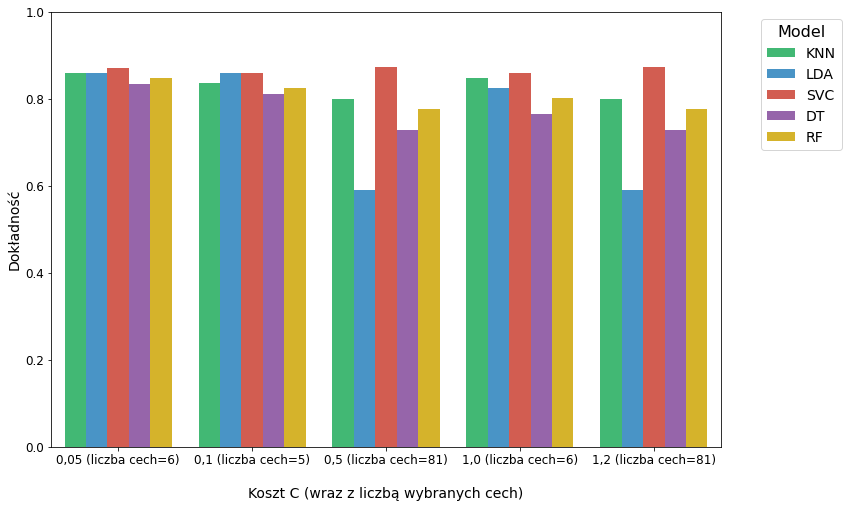

In [257]:
# Rysowanie wykresu kolumnowego
results_df['C_n_features'] = results_df['C'].astype(str) + ' (liczba cech=' + results_df['n_features'].astype(str) + ')'
palette = sns.color_palette(["#2ecc71", "#3498db", "#e74c3c", "#9b59b6", "#f1c40f"])

results_df['C'] = results_df['C'].astype(str).str.replace('.', ',')
results_df['C_n_features'] = results_df['C'] + ' (liczba cech=' + results_df['n_features'].astype(str) + ')'


# Rysowanie wykresu kolumnowego
plt.figure(figsize=(12, 8))

sns.barplot(data=results_df, x='C_n_features', y='Best Score', hue='Model', palette=palette)
plt.xlabel('\nKoszt C (wraz z liczbą wybranych cech)', fontsize=14)
plt.ylabel('Dokładność', fontsize=14)
plt.ylim([0,1])
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14,  title_fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig("images5/comparision_cost.png", bbox_inches='tight')
plt.show()

### Klasyfikacja na podstawie najważniejszych zmiennych

In [262]:
# Użycie SVC z liniowym jądrem dla RFECV
svc_linear = SVC(kernel='linear', C=0.05)

# Definiowanie RFECV z SVC (liniowym) jako estymatora
rfecv = RFECV(estimator=svc_linear, step=1, cv=4, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

# Transformowanie danych na podstawie wybranych cech
X_train_rfecv = rfecv.transform(X_train_scaled)
X_test_rfecv = rfecv.transform(X_test_scaled)

In [263]:
rfecv.n_features_

6

In [271]:
import plotly.graph_objects as go

min_features_to_select = 1
n_scores = len(rfecv.cv_results_["mean_test_score"])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(min_features_to_select, n_scores + min_features_to_select)),
    y=rfecv.cv_results_["mean_test_score"],
    mode='lines'
))

fig.update_layout(
    xaxis_title="Liczba zmiennych",
    yaxis_title="Dokładność",
    yaxis=dict(range=[0.5, 0.9]),
    xaxis=dict(range=[0, 100])
)

fig.update_layout(template="plotly_white")

fig.write_image("images5/zmienne_rfecv.png", width=1000, height=600, scale=4, format="png")

fig.show()

In [565]:
classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
}

param_grids = {
    'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'probability': [True]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'random_state': [seed]},
    'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                      'max_depth': [5, 10, 20, 30, 40, 50], 'random_state': [seed]}
}


# Przechowywanie najlepszych modeli i ich wyników
best_models_rfe = {}
best_scores_rfe = {}
test_scores_rfe = {}
best_models_rfe_class={}

# Przeszukiwanie hiperparametrów dla każdego klasyfikatora
for name, classifier in classifiers.items():
    print(f"Przetwarzanie {name}...")
    grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_rfecv, y_train)
    best_models_rfe_class[name]=grid_search.best_estimator_
    best_models_rfe[name] = (type(grid_search.best_estimator_), grid_search.best_params_)
    best_scores_rfe[name] = grid_search.best_score_
    print(f"Najlepsze parametry dla {name}: {grid_search.best_params_}")
    print(f"Najlepszy wynik dla {name}: {grid_search.best_score_}\n")

# Ocena najlepszych modeli na zbiorze testowym
for name, (model_type, best_params) in best_models_rfe.items():
    model = model_type(**best_params)
    model.fit(X_train_rfecv, y_train)
    y_pred = model.predict(X_test_rfecv)
    test_score = accuracy_score(y_test, y_pred)
    test_scores_rfe[name]=test_score
    print(f"Dokładność {name} na zbiorze testowym: {test_score}")

Przetwarzanie KNN...
Najlepsze parametry dla KNN: {'n_neighbors': 10, 'weights': 'distance'}
Najlepszy wynik dla KNN: 0.8587662337662338

Przetwarzanie LDA...
Najlepsze parametry dla LDA: {'solver': 'svd'}
Najlepszy wynik dla LDA: 0.8587662337662338

Przetwarzanie SVC...
Najlepsze parametry dla SVC: {'C': 0.1, 'kernel': 'linear', 'probability': True}
Najlepszy wynik dla SVC: 0.8706709956709957

Przetwarzanie DT...
Najlepsze parametry dla DT: {'criterion': 'gini', 'max_depth': 10, 'random_state': 42}
Najlepszy wynik dla DT: 0.8344155844155844

Przetwarzanie RF...
Najlepsze parametry dla RF: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Najlepszy wynik dla RF: 0.8468614718614719

Dokładność KNN na zbiorze testowym: 0.8636363636363636
Dokładność LDA na zbiorze testowym: 0.9090909090909091
Dokładność SVC na zbiorze testowym: 0.9090909090909091
Dokładność DT na zbiorze testowym: 0.6818181818181818
Dokładność RF na zbiorze testowym: 0.8181818181818182


In [566]:
best_scores_rfe

{'KNN': 0.8587662337662338,
 'LDA': 0.8587662337662338,
 'SVC': 0.8706709956709957,
 'DT': 0.8344155844155844,
 'RF': 0.8468614718614719}

In [568]:
best_scores_rfe==best_scores_pca

False

In [573]:
test_scores_rfe

{'KNN': 0.8636363636363636,
 'LDA': 0.9090909090909091,
 'SVC': 0.9090909090909091,
 'DT': 0.6818181818181818,
 'RF': 0.8181818181818182}

In [575]:
test_scores_pca

{'KNN': 0.8636363636363636,
 'LDA': 0.8181818181818182,
 'SVC': 0.8181818181818182,
 'DT': 0.6363636363636364,
 'RF': 0.6818181818181818}

In [576]:
best_scores_pca

{'KNN': 0.7532467532467533,
 'LDA': 0.7305194805194806,
 'SVC': 0.8116883116883117,
 'DT': 0.5876623376623377,
 'RF': 0.7418831168831169}

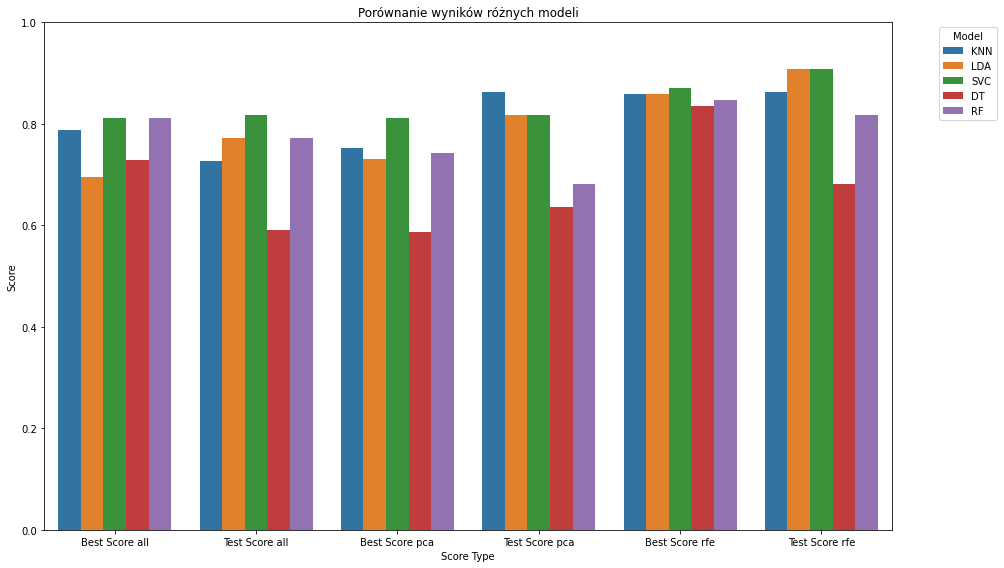

In [275]:
df = pd.DataFrame({
    'Model': best_scores_all.keys(),
    'Best Score all': best_scores_all.values(),
    'Test Score all': test_scores_all.values(),
    'Best Score pca': best_scores_pca.values(),
    'Test Score pca': test_scores_pca.values(),
    'Best Score rfe': best_scores_rfe.values(),
    'Test Score rfe': test_scores_rfe.values(),
})

# Przekształcenie ramki danych do formatu długiego
df_melted = df.melt(id_vars='Model', var_name='Score Type', value_name='Score')

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(14, 8))
sns.barplot(x='Score Type', y='Score', hue='Model', data=df_melted)

# Dostosowanie wyglądu wykresu
plt.title('Porównanie wyników różnych modeli')
plt.ylabel('Score')
plt.xlabel('Score Type')
plt.ylim(0, 1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [634]:
best_models_rfe

{'KNN': (sklearn.neighbors._classification.KNeighborsClassifier,
  {'n_neighbors': 10, 'weights': 'distance'}),
 'LDA': (sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
  {'solver': 'svd'}),
 'SVC': (sklearn.svm._classes.SVC,
  {'C': 0.1, 'kernel': 'linear', 'probability': True}),
 'DT': (sklearn.tree._classes.DecisionTreeClassifier,
  {'criterion': 'gini', 'max_depth': 10, 'random_state': 42}),
 'RF': (sklearn.ensemble._forest.RandomForestClassifier,
  {'criterion': 'entropy',
   'max_depth': 5,
   'n_estimators': 10,
   'random_state': 42})}

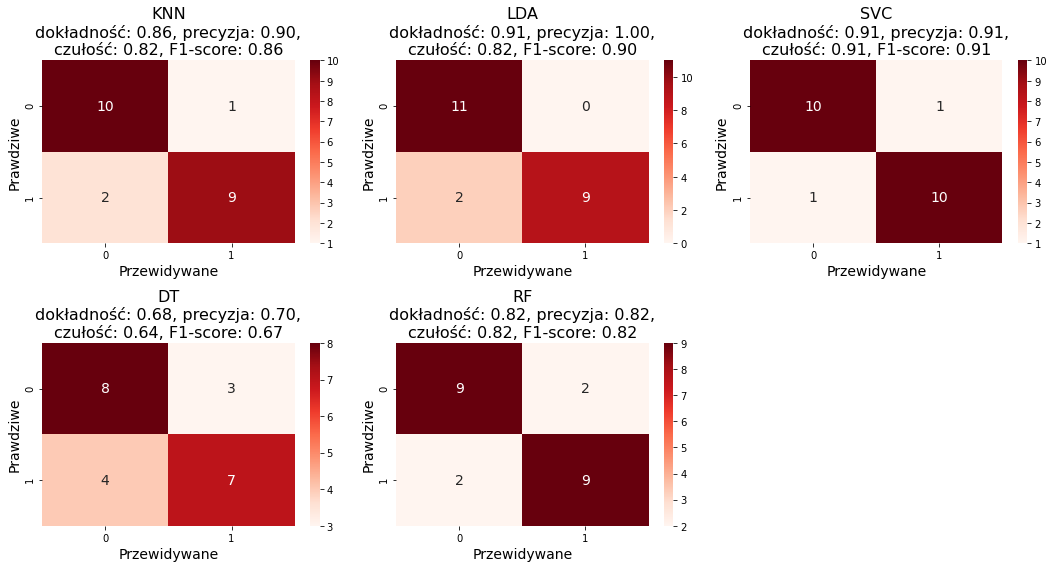

In [279]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Lista tytułów
titles = ['KNN', 'LDA', 'SVC', 'DT', 'RF']

# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_rfe.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train_rfecv, X_test_rfecv, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_rfe.png")

plt.show()

In [330]:
import shap

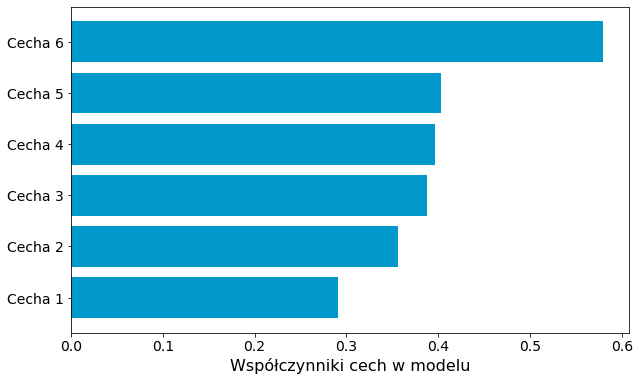

In [649]:
(model_type, best_params)=best_models_rfe["SVC"]
model = model_type(**best_params)
model.fit(X_train_rfecv,  y_train)

# Uzyskanie współczynników cech
coefs = model.coef_[0]

# Stworzenie wykresu współczynników cech
feature_names = ["Cecha 1", "Cecha 2", "Cecha 3", "Cecha 4", "Cecha 5", "Cecha 6"] #

# Posortowanie cech według ich współczynników
sorted_idx = np.argsort(coefs)
sorted_coefs = coefs[sorted_idx]
sorted_features = feature_names #feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_coefs, color='#0097ca')
plt.xlabel("Współczynniki cech w modelu", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title("Istotność cech w modelu SVC z liniową funkcją jądra")
plt.savefig("images5/waznosc_cech.png")
plt.show()
# y_pred = model.predict(X_test_rfecv)
# y_pred!=y_test

In [337]:
feature_names

Index(['BETET_kw__number_peaks__n_2', 'BETET_kw__first_location_of_minimum',
       'HCO3STTE_kw__first_location_of_maximum', 'IONH_kw__number_peaks__n_2',
       'IONH_kw__first_location_of_maximum',
       'euclidean_kw__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"'],
      dtype='object')

In [336]:
model.coef_

array([[0.29041801, 0.35581356, 0.38829795, 0.39663056, 0.4034219 ,
        0.57895974]])

In [467]:
y_pred = model.predict(X_test_rfecv)
por=y_test.reset_index()
por["y_pred"]=y_pred
por.iloc[np.where(por["ZGON"]!=por["y_pred"])]["index"]

3     59
17    13
Name: index, dtype: int64

In [415]:
X_train_df = pd.DataFrame(X_train_rfecv).reset_index(drop=True)
# columns=feature_names
# Przekształcenie y_train do DataFrame i nadanie kolumnie nazwy "ZGON"
y_train_df = pd.DataFrame(y_train, columns=["ZGON"]).reset_index(drop=True)

# Połączenie X_train_df i y_train_df wzdłuż osi kolumn (axis=1)
data_6_vars = pd.concat([X_train_df, y_train_df], axis=1)

# Wyświetlenie wynikowej ramki danych
data_6_vars
# X_train_df

,0,1,2,3,4,5,ZGON
0,-0.533745,-0.501839,-0.623985,-0.987935,-0.755434,-0.053396,0.0
1,0.762493,0.227663,-0.623985,1.202703,0.958038,0.056642,1.0
2,-0.533745,0.573217,-0.623985,0.472490,-0.838153,1.786529,1.0
3,3.354969,1.011203,1.942238,1.932916,-0.642078,-1.146171,1.0
4,-0.533745,-0.501839,-0.623985,-0.257722,-0.507276,-0.937335,1.0
...,...,...,...,...,...,...,...
80,-0.533745,-0.501839,-0.623985,0.472490,-0.705802,-0.209600,0.0
81,-0.533745,0.136475,-0.623985,-0.257722,-0.341837,-2.844536,0.0
82,-0.533745,-0.501839,-0.623985,-0.987935,-0.698837,-0.262347,0.0
83,0.762493,-0.501839,-0.390220,0.472490,-0.791714,-0.396241,0.0


In [395]:
feature_names_skr=['BETET_piki', 'BETET_loc_min',
       'HCO3STTE_loc_max', 'IONH_piki',
       'IONH_loc_max',
       'mean_slope_miernik2']

In [526]:
# Wyświetlenie wynikowej ramki danych
data_6_vars=data_with_features[[*names[rfecv.support_], "ZGON", "PACJENT_NR"]]
# data_6_vars.columns=[0,1,2,3,4,5,"ZGON"]
data_6_vars.columns=[*feature_names, "ZGON", "PACJENT_NR"]
data_6_vars.columns

Index(['Cecha 1', 'Cecha 2', 'Cecha 3', 'Cecha 4', 'Cecha 5', 'Cecha 6',
       'ZGON', 'PACJENT_NR'],
      dtype='object')

In [482]:
data_with_features.iloc[59]["PACJENT_NR"]
data_with_features.iloc[13]["PACJENT_NR"]

19.0

In [550]:
# cols = names[rfecv.support_]
# cols=[0, 1, 2, 3, 4, 5]
cols=["Cecha 1", "Cecha 2", "Cecha 3", "Cecha 4", "Cecha 5", "Cecha 6"]
my_blue="#0064B2"
my_red="#D61600"
fig = go.Figure()

# Użycie pd.melt() do przekształcenia ramki danych do długiego formatu
melted_data = pd.melt(data_6_vars, id_vars=["ZGON", "PACJENT_NR"], value_vars=cols,
                      var_name="Cecha", value_name="Wartość")

# Tworzenie wykresu boxplot za pomocą Plotly Express
fig = px.box(melted_data, x="Cecha", y="Wartość", color="ZGON",
             labels={"Cecha": "Cecha", "Wartość": "Wartość", "ZGON": "Klasa ZGON"}, points='all')

# Ustawienie customdata
fig.update_traces(customdata=melted_data["PACJENT_NR"])

# Dodanie numeru pacjenta do etykiet punktów
fig.update_traces(
    hovertemplate='%{x}: %{y} <br> Pacjent: %{customdata}'
)

# Dostosowanie rozmiaru czcionki osi x i y
fig.update_layout(xaxis=dict(tickfont=dict(size=18), title=""), yaxis=dict(tickfont=dict(size=16),  title=dict(font=dict(size=18))))
fig.update_layout(showlegend=False)
fig.update_layout(height=600, width=1200)
fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images5/rozklad_najw_cech.png", format="png", scale=3)

In [297]:
data_with_features.iloc[59, :]

PACJENT_NR                                                                      80.000000
ZGON                                                                             1.000000
BETET__minimum                                                                   2.000000
BETET__maximum                                                                   3.978261
BETET__mean                                                                      2.875362
                                                                                  ...    
euclidean_kw_skum__linear_trend__attr_"slope"                                    0.631768
euclidean_kw_skum__agg_linear_trend__attr_"slope"__chunk_len_3__f_agg_"mean"     1.871573
euclidean_kw_skum__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"     3.167514
euclidean_kw_skum__agg_linear_trend__attr_"slope"__chunk_len_3__f_agg_"max"      1.697348
euclidean_kw_skum__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"max"      2.603618
Name: 59, 

In [277]:
names[rfecv.support_]

Index(['BETET_kw__number_peaks__n_2', 'BETET_kw__first_location_of_minimum',
       'HCO3STTE_kw__first_location_of_maximum', 'IONH_kw__number_peaks__n_2',
       'IONH_kw__first_location_of_maximum',
       'euclidean_kw__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"'],
      dtype='object')

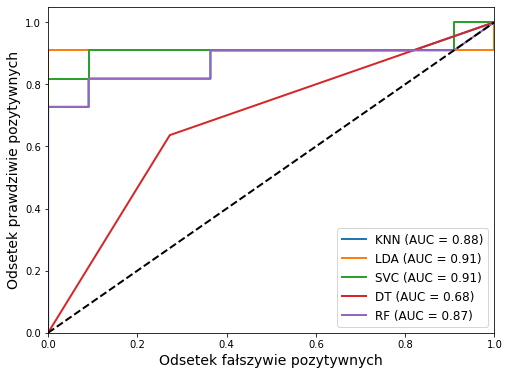

In [278]:
# Krzywe ROC
plt.figure(figsize=(8, 6))
for name, (model_type, best_params) in best_models_rfe.items():
    model = model_type(**best_params)
    model.fit(X_train_rfecv, y_train)
    y_pred = model.predict(X_test_rfecv)
    fpr, tpr, roc_auc= model_evaluate(model, X_train_rfecv, X_test_rfecv, y_train, y_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')  # Grubsze linie

# Dodanie linii diagonalnej
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ustawienia osi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Powiększenie napisów przy osiach
plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=14)
plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=14)

# Powiększenie legendy
plt.legend(loc='lower right', fontsize=12)

plt.savefig("images5/roc_rfe.png")
# Wyświetlenie wykresu
plt.show()



### Klasyfikacja w czasie

In [300]:
chosen_vars=['BETET_kw', 'HCO3STTE_kw', 'IONH_kw', 'euclidean_kw']

data_to_extract2=data_to_extract[['PACJENT_NR', 'BADANIE_NR', *chosen_vars]]

selected_features_dict = {
    'BETET_kw': {
        'number_peaks': [{'n': 2}],
        'first_location_of_minimum': None
    },
    'IONH_kw': {
        'number_peaks': [{'n': 2}],
        'first_location_of_maximum': None
    },
    'HCO3STTE_kw': {
        'first_location_of_maximum': None
    },
    'euclidean_kw': {
        'agg_linear_trend': [{'f_agg': 'mean', 'chunk_len': 6, 'attr': 'slope'}]
    }
}

In [ ]:
from sklearn.utils import resample

In [ ]:
X_data.shape

In [302]:
results2 = []

for n_badan in range(1, 65):
    # Filtrowanie danych do n_badan
    data_subset = data_to_extract2[data_to_extract2['BADANIE_NR'] <= n_badan]

    extracted_features_6 = pd.DataFrame()

    # Iteracja po wybranych zmiennych
    for col in chosen_vars:
        selected_features = selected_features_dict.get(col, {})
        features = extract_features(data_subset, column_id="PACJENT_NR", column_sort="BADANIE_NR", 
                                    column_value=col, default_fc_parameters=selected_features)
        features.columns = [f"{col}_{feature}" for feature in features.columns]
        extracted_features_6 = pd.concat([extracted_features_6, features], axis=1)

    # Przygotowanie danych do modelowania
    X = extracted_features_6.dropna(axis=1, how='all')

    # Podział danych na zbiory treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # Standaryzacja danych
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
    }

    param_grids = {
    'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'probability': [True]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'random_state': [seed]},
    'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                      'max_depth': [5, 10, 20, 30, 40, 50], 'random_state': [seed]}
    }

    best_models_for_n={}
    test_scores_for_n={}

    # Przeszukiwanie hiperparametrów dla każdego klasyfikatora
    for name, classifier in classifiers.items():
        grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_train)
        
        model_type=type(classifier)
        best_params=grid_search.best_params_

        test_scores=[]
        recalls=[]
        precisions=[]
        f1_scores=[]
        
        for i in range(100):
            X_btrain, X_btest, y_btrain, y_btest = train_test_split(X, y, test_size=0.2, random_state=i, stratify=y)

            scaler2 = StandardScaler()
            X_btrain_scaled = scaler2.fit_transform(X_btrain)
            X_btest_scaled = scaler2.transform(X_btest)

            best_model=model_type(**best_params)
            best_model.fit(X_btrain_scaled, y_btrain)
            y_bpred = best_model.predict(X_btest_scaled)
            test_scores.append(accuracy_score(y_btest, y_bpred))
            precisions.append(precision_score(y_btest, y_bpred))
            recalls.append(recall_score(y_btest, y_bpred))
            f1_scores.append(f1_score(y_btest, y_bpred))
        
        mean_test_score=np.mean(test_scores)
        mean_recall=np.mean(recalls)
        mean_precision=np.mean(precisions)
        mean_f1_score=np.mean(f1_scores)

        best_model=model_type(**best_params)
        best_model.fit(X_train_scaled, y_train)
        y_pred = best_model.predict(X_test_scaled)
        test_acc=accuracy_score(y_test, y_pred)
        test_prec=precision_score(y_test, y_pred)
        test_recall=recall_score(y_test, y_pred)
        test_f1=f1_score(y_test, y_pred)
    
        results2.append({'n_badan': n_badan, 'Model': name, 'parameters': best_params, 'Dokładność test': test_acc, 'Czułość test': test_recall, 
                         'Precyzja test': test_prec, 'F1-score test': test_f1, 'Dokładność 100 test': mean_test_score, 'Czułość 100 test': mean_recall, 
                         'Precyzja 100 test': mean_precision, 'F1-score 100 test': mean_f1_score})

    # # Ocena najlepszych modeli na zbiorze testowym
    # for name, (model_type, best_params) in best_models_for_n.items():
    #     model = model_type(**best_params)
    #     model.fit(X_train_scaled, y_train)
    #     y_pred = model.predict(X_test_scaled)
    #     test_score = accuracy_score(y_test, y_pred)
    #     results2.append({'n_badan': n_badan, 'Model': name, 'Dokładność': test_score, 'parameters': best_models_for_n[name]})

Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  5.94it/s]
c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: Undefined

In [303]:
results_df=pd.DataFrame(results2)
results_df.head(20)

,n_badan,Model,parameters,Dokładność test,Czułość test,Precyzja test,F1-score test,Dokładność 100 test,Czułość 100 test,Precyzja 100 test,F1-score 100 test
0,1,KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",0.500000,1.000000,0.500000,0.666667,0.500000,0.580000,0.290000,0.386667
1,1,LDA,{'solver': 'lsqr'},0.500000,1.000000,0.500000,0.666667,0.500000,1.000000,0.500000,0.666667
2,1,SVC,"{'C': 0.1, 'kernel': 'linear', 'probability': ...",0.500000,1.000000,0.500000,0.666667,0.500000,1.000000,0.500000,0.666667
3,1,DT,"{'criterion': 'gini', 'max_depth': 10, 'random...",0.500000,1.000000,0.500000,0.666667,0.500000,1.000000,0.500000,0.666667
4,1,RF,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.500000,1.000000,0.500000,0.666667,0.500000,0.840000,0.420000,0.560000
5,2,KNN,"{'n_neighbors': 15, 'weights': 'uniform'}",0.772727,0.727273,0.800000,0.761905,0.610000,0.605455,0.624096,0.599804
6,2,LDA,{'solver': 'svd'},0.772727,0.727273,0.800000,0.761905,0.645909,0.607273,0.668385,0.626982
7,2,SVC,"{'C': 0.5, 'kernel': 'linear', 'probability': ...",0.772727,0.727273,0.800000,0.761905,0.647727,0.602727,0.671095,0.626504
8,2,DT,"{'criterion': 'gini', 'max_depth': 10, 'random...",0.636364,0.454545,0.714286,0.555556,0.617273,0.577273,0.635645,0.592836
9,2,RF,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.636364,0.454545,0.714286,0.555556,0.617273,0.590000,0.632313,0.598367


In [ ]:
df=results_df[['n_badan', 'Model', 'Dokładność 100 test', 'Precyzja 100 test', 'Czułość 100 test', 'F1-score 100 test']]
df

In [ ]:
df2=df[df["n_badan"]==3]
df2.drop(columns='n_badan', inplace=True)

# Przekształcenie za pomocą melt
df_melted = df2.melt(id_vars=['Model'], var_name='Metryka', value_name='Wartość')

# Generowanie wykresu słupkowego
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Wartość', hue='Metryka', data=df_melted)

# Dodanie etykiet i tytułów
ax.set_xlabel('Numer badania')
ax.set_ylabel('Wartości')
ax.set_title('Porównanie metryk dla różnych badań')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
x_label='Numer badania'
title='klasyfikacja_obserwacje_accuracy'
# results_df = results_df[results_df['Model'].isin(['LDA', 'KNN'])]
fig = px.line(results_df, x='n_badan', y='Precyzja 100 test', color='Model', markers=True, line_shape='linear')

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title=x_label,
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Dokładność',
        tickfont=dict(size=16),
        title_font=dict(size=20),
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images5/wykresy_w_czasie_lda_knn.png", width=1000, height=600, scale=4, format="png")
fig.write_image("images5/wykresy_w_czasie_10_czułość.png", width=1000, height=600, scale=4, format="png")

In [562]:
x_label='Numer badania'
title='klasyfikacja_obserwacje_accuracy'
# results_df = results_df[results_df['Model'].isin(['LDA', 'KNN'])]
fig = px.line(results_df, x='n_badan', y='F1-score 100 test', color='Model', markers=True, line_shape='linear')

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title=x_label,
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='F1-score',
        tickfont=dict(size=16),
        title_font=dict(size=20),
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")
fig.show()
# fig.write_image("images5/wykresy_w_czasie_lda_knn.png", width=1000, height=600, scale=4, format="png")
fig.write_image("images5/wykresy_w_czasie_100_fscore.png", width=1000, height=600, scale=4, format="png")

In [560]:
# results_df2=results_df[results_df['n_badan']>=1]

x_label='Numer badania'
title='klasyfikacja_obserwacje_accuracy'
# results_df = results_df[results_df['Model'].isin(['LDA', 'KNN'])]
fig = px.line(results_df, x='n_badan', y='Dokładność 100 test', color='Model', markers=True, line_shape='linear')

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title=x_label,
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Dokładność',
        tickfont=dict(size=16),
        title_font=dict(size=20),
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images5/wykresy_w_czasie_100_dokladnosc_test.png", width=1000, height=600, scale=4, format="png")

In [555]:

best_models_for_n

0             {'n_neighbors': 5, 'weights': 'uniform'}
1                                   {'solver': 'lsqr'}
2    {'C': 0.1, 'kernel': 'linear', 'probability': ...
3    {'criterion': 'gini', 'max_depth': 10, 'random...
4    {'criterion': 'gini', 'max_depth': 5, 'n_estim...
Name: parameters, dtype: object

In [558]:
X

,BETET_kw_BETET_kw__number_peaks__n_2,BETET_kw_BETET_kw__first_location_of_minimum,HCO3STTE_kw_HCO3STTE_kw__first_location_of_maximum,IONH_kw_IONH_kw__number_peaks__n_2,IONH_kw_IONH_kw__first_location_of_maximum
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
139,0.0,0.0,0.0,0.0,0.0
140,0.0,0.0,0.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0


Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


TypeError: n_neighbors argument after ** must be a mapping, not str

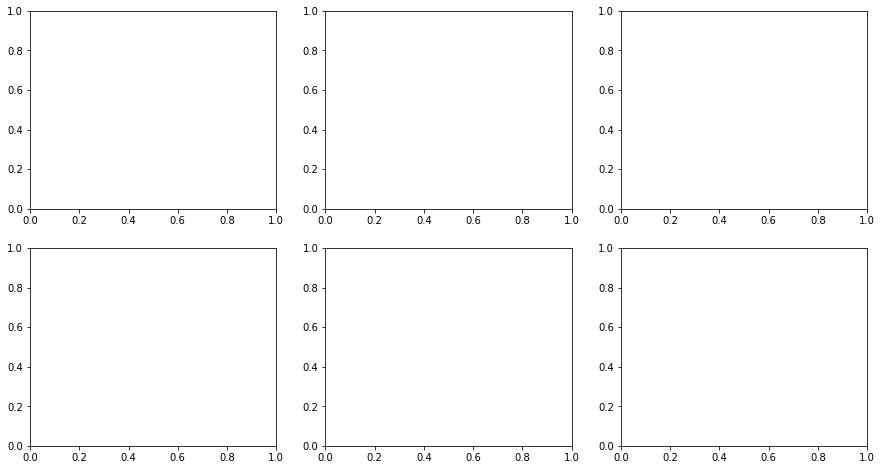

In [617]:
# Ocena najlepszych modeli na zbiorze testowym
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Lista tytułów
titles = ['KNN', 'LDA', 'SVC', 'DT', 'RF']

best_models_for_n=results_df[results_df["n_badan"]==6]["parameters"]
data_subset = data_to_extract2[data_to_extract2['BADANIE_NR'] <= 6]

extracted_features_6 = pd.DataFrame()

# Iteracja po wybranych zmiennych
for col in chosen_vars:
    selected_features = selected_features_dict.get(col, {})
    features = extract_features(data_subset, column_id="PACJENT_NR", column_sort="BADANIE_NR", 
                                    column_value=col, default_fc_parameters=selected_features)
    features.columns = [f"{col}_{feature}" for feature in features.columns]
    extracted_features_6 = pd.concat([extracted_features_6, features], axis=1)

    # Przygotowanie danych do modelowania
X = extracted_features_6.dropna(axis=1, how='all')

    # Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_for_n.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train_scaled, X_test_scaled, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_n_badan1.png")

plt.show()

In [641]:
best_models_for_n={
    'KNN': (sklearn.neighbors._classification.KNeighborsClassifier,
            {'n_neighbors': 20, 'weights': 'uniform'}),
    'LDA': (sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
            {'solver': 'svd'}),
    'SVC': (sklearn.svm._classes.SVC,
            {'C': 1.5, 'kernel': 'sigmoid', 'probability': True}),
    'DT': (sklearn.tree._classes.DecisionTreeClassifier,
            {'criterion': 'gini', 'max_depth': 10, 'random_state': 42}),
    'RF': (sklearn.ensemble._forest.RandomForestClassifier,
            {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 10, 'random_state': 42})
}
# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_for_n.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train_scaled, X_test_scaled, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_n_badan1.png")

plt.show()

NameError: name 'sklearn' is not defined

In [631]:
best_models_for_n

KNN            {'n_neighbors': 20, 'weights': 'uniform'}
LDA                                    {'solver': 'svd'}
SVC    {'C': 1.5, 'kernel': 'sigmoid', 'probability':...
DT     {'criterion': 'gini', 'max_depth': 10, 'random...
RF     {'criterion': 'entropy', 'max_depth': 5, 'n_es...
Name: parameters, dtype: object

In [633]:
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models_for_n.items()):
    print(title)


KNN


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
y_pred<=y_test

In [642]:
n_badan=6
# Filtrowanie danych do n_badan
data_subset = data_to_extract2[data_to_extract2['BADANIE_NR'] <= n_badan]

extracted_features_6 = pd.DataFrame()

# Iteracja po wybranych zmiennych
for col in chosen_vars:
    selected_features = selected_features_dict.get(col, {})
    features = extract_features(data_subset, column_id="PACJENT_NR", column_sort="BADANIE_NR", 
                                column_value=col, default_fc_parameters=selected_features)
    features.columns = [f"{col}_{feature}" for feature in features.columns]
    extracted_features_6 = pd.concat([extracted_features_6, features], axis=1)

# Przygotowanie danych do modelowania
X6 = extracted_features_6.dropna(axis=1, how='all')

# Podział danych na zbiory treningowy i testowy
X_train6, X_test6, y_train, y_test = train_test_split(X6, y, test_size=0.2, random_state=seed, stratify=y)

# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled6 = scaler.fit_transform(X_train6)
X_test_scaled6 = scaler.transform(X_test6)

classifiers = {
'KNN': KNeighborsClassifier(),
'LDA': LinearDiscriminantAnalysis(),
'SVC': SVC(),
'DT': DecisionTreeClassifier(),
'RF': RandomForestClassifier()
}

param_grids = {
'KNN': {'n_neighbors': [5,10,15,20], 'weights': ['uniform', 'distance']},
'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
'SVC': {'C': [0.1, 0.5, 1, 1.5], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'probability': [True]},
'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50], 'random_state': [seed]},
'RF': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 
                    'max_depth': [5, 10, 20, 30, 40, 50], 'random_state': [seed]}
}

# Przechowywanie najlepszych modeli i ich wyników
best_models6 = {}
best_scores6 = {}
test_scores6 = {}
best_models_class6={}

# Przeszukiwanie hiperparametrów dla każdego klasyfikatora
for name, classifier in classifiers.items():
    print(f"Przetwarzanie {name}...")
    grid_search = GridSearchCV(classifier, param_grids[name], cv=4, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train6, y_train)
    best_models_class6[name]=grid_search.best_estimator_
    best_models6[name] = (type(grid_search.best_estimator_), grid_search.best_params_)
    best_scores6[name] = grid_search.best_score_
    print(f"Najlepsze parametry dla {name}: {grid_search.best_params_}")
    print(f"Najlepszy wynik dla {name}: {grid_search.best_score_}\n")

# Ocena najlepszych modeli na zbiorze testowym
for name, (model_type, best_params) in best_models6.items():
    model = model_type(**best_params)
    model.fit(X_train6, y_train)
    y_pred = model.predict(X_test6)
    test_score = accuracy_score(y_test, y_pred)
    test_scores6[name]=test_score
    print(f"Dokładność {name} na zbiorze testowym: {test_score}")



Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


Przetwarzanie KNN...
Najlepsze parametry dla KNN: {'n_neighbors': 15, 'weights': 'uniform'}
Najlepszy wynik dla KNN: 0.6699134199134199

Przetwarzanie LDA...
Najlepsze parametry dla LDA: {'solver': 'svd'}
Najlepszy wynik dla LDA: 0.6347402597402597

Przetwarzanie SVC...
Najlepsze parametry dla SVC: {'C': 1.5, 'kernel': 'sigmoid', 'probability': True}
Najlepszy wynik dla SVC: 0.658008658008658

Przetwarzanie DT...
Najlepsze parametry dla DT: {'criterion': 'gini', 'max_depth': 10, 'random_state': 42}
Najlepszy wynik dla DT: 0.5162337662337663

Przetwarzanie RF...
Najlepsze parametry dla RF: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Najlepszy wynik dla RF: 0.5995670995670995

Dokładność KNN na zbiorze testowym: 0.5909090909090909
Dokładność LDA na zbiorze testowym: 0.6818181818181818
Dokładność SVC na zbiorze testowym: 0.6363636363636364
Dokładność DT na zbiorze testowym: 0.5909090909090909
Dokładność RF na zbiorze testowym: 0.5454545454545454


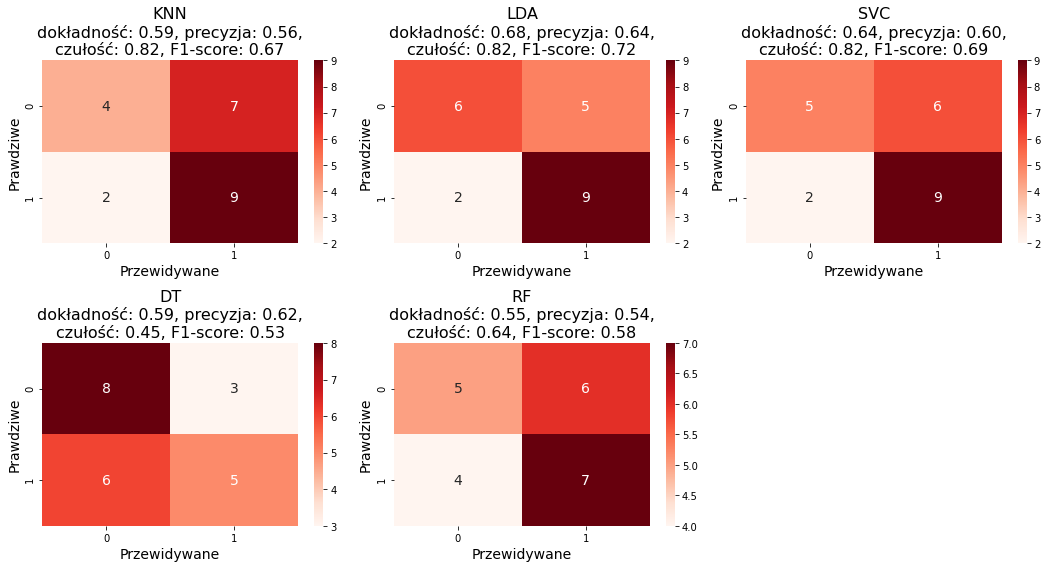

In [643]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Lista tytułów
titles = ['KNN', 'LDA', 'SVC', 'DT', 'RF']

# Rysowanie macierzy pomyłek dla każdego klasyfikatora
for ax, (title, (model_type, best_params)) in zip(axes.flatten(), best_models6.items()):
    model = model_type(**best_params)
    plot_confusion_matrix(model, X_train6, X_test6, y_train, y_test, ax, title)

# Usuwanie niepotrzebnych osi w przypadku parzystej liczby klasyfikatorów
if len(classifiers) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()

plt.savefig("images5/conf_matr_6.png")

plt.show()